# SatSAM

In this notebook, we will finetune SAM on Aerial Image Dataset for building extraction.

Let's start by importing the necessary libraries:

In [1]:
import sys

sys.path.append("../")

In [2]:
from segmate.segmenter import SAM
from segmate import utils
import datasets
import numpy as np
import torch
from tqdm import tqdm
from torch.nn import functional as F
from statistics import mean
import os
from segmate.dataset import AerialImageDataset

### Initializing SAM

To start using SegMate, we need to create an instance of the SAM class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_h` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [3]:
model_checkpoint = '/ssd003/projects/aieng/image_models/sam_vit_b.pth'

In [4]:
sm = SAM(model_type='vit_b', checkpoint=model_checkpoint, device='cuda')

In [5]:
# Function to calculate center of a building mask
def calculate_centers(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX, cY))
    return centers

# Function to calculate bounding boxes around all buildings
def calculate_bounding_boxes(contours):
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x+w, y+h))
    return bounding_boxes

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = '/scratch/ssd004/scratch/vkhazaie/AerialImageDataset_spilt_patch/train/images/austin1_0_0.png'
image = cv2.imread(image_path)
mask_path = '/scratch/ssd004/scratch/vkhazaie/AerialImageDataset_spilt_patch/train/gt/austin1_0_0.png'
gt_mask = cv2.imread(mask_path, 0)

# Threshold the image to make sure it's binary
_, binary_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)

# Find contours which corresponds to the buildings
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
# Calculate centers and bounding boxes
centers = calculate_centers(contours)
bounding_boxes = calculate_bounding_boxes(contours)

In [8]:
gt_mask_ext_c = np.expand_dims(gt_mask, axis=0)
gt_mask_ext_c = np.concatenate((gt_mask_ext_c, gt_mask_ext_c, gt_mask_ext_c), axis=0)
gt_mask_ext_c = np.expand_dims(gt_mask_ext_c, axis=0)

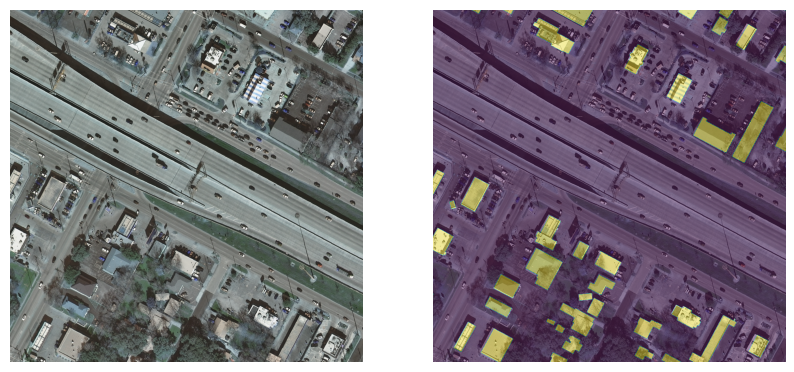

In [9]:
utils.show_masks(image, gt_mask_ext_c, size=5)

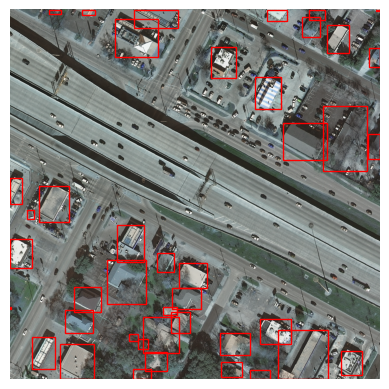

In [10]:
utils.show_bounding_boxes(image, utils.convert_sam_to_coco(bounding_boxes))

In [11]:
building_mask_bb = sm.segment(image, boxes_prompt=bounding_boxes)

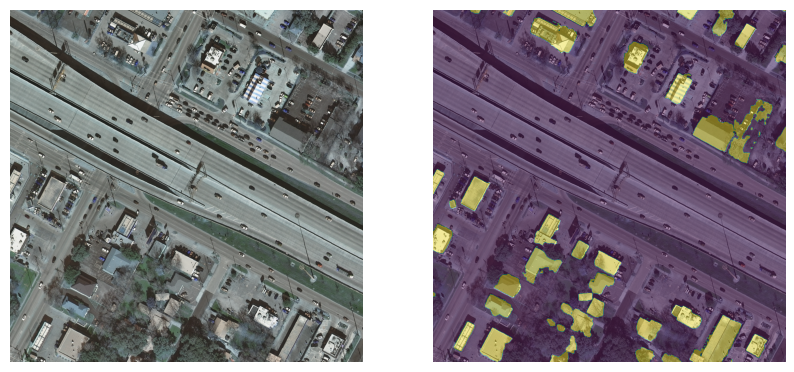

In [12]:
utils.show_masks(image, building_mask_bb, size=5)

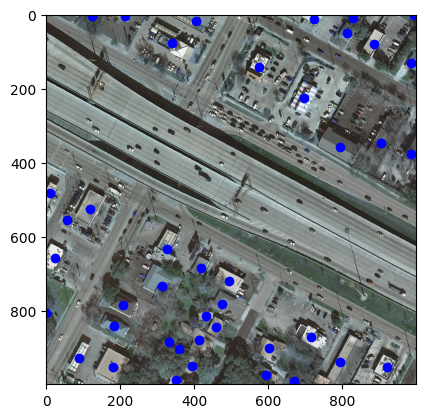

In [13]:
centers_labels = np.ones(len(centers))
utils.show_points(image, centers, centers_labels)

In [14]:
building_mask_p = sm.segment(image, points_prompt=[centers, centers_labels])

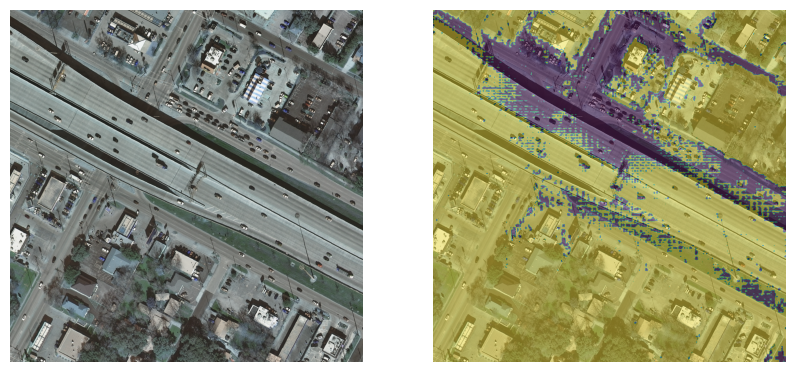

In [15]:
utils.show_masks(image, building_mask_p, size=5)

In [16]:
ai_dataset = AerialImageDataset(data_dir="/scratch/ssd004/scratch/vkhazaie/AerialImageDataset_spilt_patch/train",
                                preprocess=sm.sam.preprocess,
                                img_size=sm.sam.image_encoder.img_size,
                                device=sm.device)

In [17]:
# create a pytorch data loader
# note: the batch size should be 1
train_loader = torch.utils.data.DataLoader(ai_dataset, batch_size=1, shuffle=False)

In [18]:
criterion = torch.nn.MSELoss()

satsam_params = list(sm.sam.image_encoder.parameters()) + list(sm.sam.mask_decoder.parameters())

optimizer = torch.optim.AdamW(satsam_params, lr=1e-4, weight_decay=1e-2)

sm.sam.train()

for param in sm.sam.prompt_encoder.parameters():
    param.requires_grad = False

num_epochs = 10

In [ ]:
for epoch in range(1, num_epochs + 1):
    epoch_losses = []
    for input_image, boxes_prompt, gt_mask in tqdm(train_loader):
        # check to see if there are masks or bounding boxes for the image
        if boxes_prompt.shape[1] != 0:
            if len(boxes_prompt.shape) > 2:
                boxes_prompt = boxes_prompt.squeeze()

            # encode the image and the prompt with sam's encoders, frozen weights
            image_embedding = sm.sam.image_encoder(input_image)

            # encoding the prompt with sam's prompt encoder
            sparse_embeddings, dense_embeddings = sm.sam.prompt_encoder(
                points=None,
                boxes=boxes_prompt,
                masks=None,
            )

            # generating the segmentation mask from the image and the prompt embeddings
            low_res_masks, _ = sm.sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=sm.sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            upscaled_masks = sm.sam.postprocess_masks(low_res_masks, 
                                                      tuple(input_image.shape[-2:]), 
                                                      1000)
            thresholded_mask = F.threshold(upscaled_masks, 0.0, 0)
            binary_mask = F.normalize(thresholded_mask)
            pred_mask = binary_mask.sum(axis=0).unsqueeze(0)

            # compute loss
            gt_mask = gt_mask / 255.
            loss = criterion(pred_mask, gt_mask)

            # backward pass (compute gradients of parameters w.r.t. loss)
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()
            epoch_losses.append(loss.item())
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

    checkpoint = {
    "model": sm.sam.state_dict(),
    "optimizer": optimizer.state_dict(),
    "epoch": epoch,
    }
    torch.save(checkpoint, os.path.join("../../", "satsam.pth"))

  0%|▍                                                                                                                                                                          | 10/3600 [00:05<33:32,  1.78it/s]